# Applications of DFA to a phase transition in a stochastic Wilson Cowan model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dfa_functions import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import matplotlib

In [5]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 20

In [6]:
from numba import njit, jit, prange

Here I focus on the following stochastic Wilson Cowan model. The single unit dynamics is described by the following equations, which include the activity of an excitatory subpopulation and of an inhibitory subpopulation:

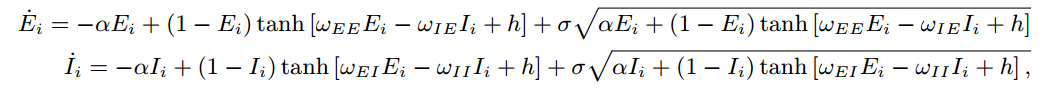

The deterministic part of this model is not able to reproduce oscillations, while once noise is turned on, in a certain region of parameters a noise induced limit cycle appears in the single unit dynamics.
Moreover, I consider many units which are diffusively coupled on a lattice. Once coupling is present, synchronization among the units appear as well as robust collective oscillations. 
In particular, depending on the parameter values, the network admits a down state, collective oscillations or an up state.
In this notebook I will focus on the transition from the state of collective oscillation to the up state.

In [7]:
## Here I build a 2D lattice with 64 units

In [8]:
lato = 8
Omega = lato**2
import numpy as np
A=np.zeros([Omega,Omega])
for i in range(Omega):
    if i - int(i/lato)*lato != (lato - 1)  and i + 1 < lato*lato:
        A[i, i + 1]=1
        A[i+1,i] = 1
        
    if i + lato < lato*lato:
        A[i, i + lato]=1
        A[i+lato,i] = 1
        
        
K=np.zeros([Omega,Omega])
for i in range(Omega):
    for j in range(Omega):
        if i==j:
            K[i,j]=np.sum(A[i])

L=A-K ## Laplacian

In [9]:
import networkx as nx

In [10]:
pos = {}
for s in range(lato):
    for r in range(lato):
        pos[s +r*lato] = [s,r]

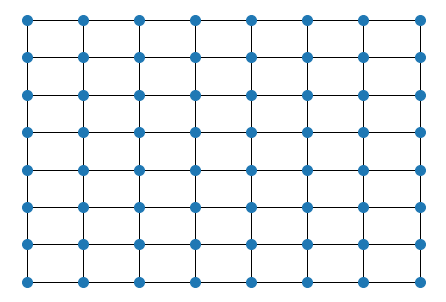

In [11]:
G = nx.Graph(A)
nx.draw(G,pos = pos,node_size =100)

In [12]:
@njit
def WilsonExcCoupled(dt,T,nunits,omegaEE,omegaEI, omegaII,omegaIE, alpha, h, noise,L):
    
    def fun(l):
        idx = l <0
        idx1 = l >=0
        n = l.copy()
        n[idx]= 0
        n[idx1] = np.tanh(l[idx1])
        return n

    D = 1
    N = int(T/dt)
    wil = np.random.random((2, N, nunits))

    
    for r in range(N-1):
        
        #################
        idx = wil[0,r] <0
        idx2 = wil[0,r] >1
        wil[0,r][idx] = 0
        wil[0,r][idx2] = 1
        
        idx = wil[1,r] <0
        idx2 = wil[1,r] >1
        wil[1,r][idx] = 0
        wil[1,r][idx2] = 1
        ##################
        
        wil[0,r+1] = wil[0,r] - alpha*wil[0,r]*dt + (1-wil[0,r])*fun(omegaEE*wil[0,r]- omegaIE*wil[1,r] + D*L @ wil[0,r]+ h)*dt + np.sqrt(alpha*wil[0,r] + (1-wil[0,r])*fun(omegaEE*wil[0,r]- omegaIE*wil[1,r] + D*L @wil[0,r] + h))*np.sqrt(dt)*np.random.randn(nunits)*noise
        wil[1,r+1] = wil[1,r] - alpha*wil[1,r]*dt + (1-wil[1,r])*fun(omegaEI*wil[0,r]- omegaII*wil[1,r] + h)*dt + np.sqrt(alpha*wil[1,r] + (1-wil[1,r])*fun(omegaEI*wil[0,r]- omegaII*wil[1,r] + h))*np.sqrt(dt)*np.random.randn(nunits)*noise
    return wil

In [13]:
alpha =0.1
h = 1e-3

omegaEE = 18
omegaIE =  14
omegaEI = 4.65
omegaII = 2.8
noise = 0.05
T = 10000
dt =0.001
wilup = WilsonExcCoupled(dt,T,lato**2,omegaEE,omegaEI,omegaII,omegaIE,alpha,h,noise,L)

In [14]:
mup = np.mean(wilup,2)[0]

In [15]:
del wilup

In this region of parameter the network converges to an up state of activity. Here I plot the density of the activity of the excitatory nodes in the network.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


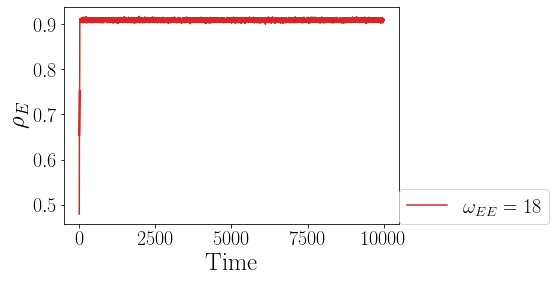

In [16]:
time = np.arange(0,T,dt)
plt.plot(time,mup, label = '$\omega_{EE} = 18$', color = 'tab:red')
plt.xlabel('Time')
plt.ylabel(r'$\rho_E$')
plt.legend(loc =(1,0));

In [17]:
alpha =0.1
h = 1e-3
omegaEE = 16
omegaIE =  14
omegaEI = 4.65
omegaII = 2.8
noise = 0.05
T = 10000
dt =0.001

wilcrit = WilsonExcCoupled(dt,T,lato**2,omegaEE,omegaEI,omegaII,omegaIE,alpha,h,noise,L)

In [18]:
mcrit = np.mean(wilcrit,2)[0]

In [19]:
del wilcrit

In this region of parameter the network admits an up state, whose basin of attraction is however very small and the noise can destabilize it causing excursions in the down state. This is due to the non-normality of the matrix describing the single unit dynamics (See this [ref](https://arxiv.org/abs/1803.07858)).
This region of parameters likely marks a critical point between the up state and the collective oscillations state.

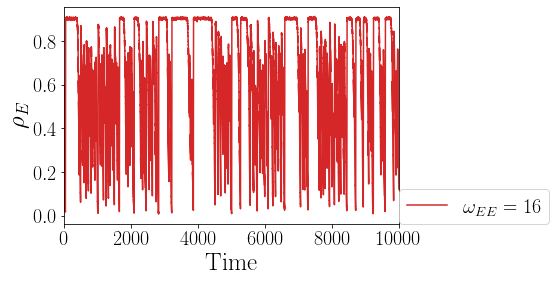

In [36]:
time = np.arange(0,T,dt)
plt.plot(time,mcrit, label = '$\omega_{EE} = 16$', color = 'tab:red')
plt.xlabel('Time')
plt.ylabel(r'$\rho_E$')
plt.legend(loc = (1,0));
plt.xlim(0,10000);

In [21]:
alpha =0.1
h = 1e-3
omegaEE = 15
omegaIE =  14
omegaEI = 4.65
omegaII = 2.8
noise = 0.05
T = 10000
dt =0.001

wilsinc = WilsonExcCoupled(dt,T,lato**2,omegaEE,omegaEI,omegaII,omegaIE,alpha,h,noise,L)

In [22]:
msinc = np.mean(wilsinc,2)[0]

In [23]:
del wilsinc

For these values of parameters instead the network presents collective oscillations (which would be absent in the absence of noise).

In [ ]:
time = np.arange(0,T,dt)
plt.plot(time,msinc, label = '$\omega_{EE} = 15$', color = 'tab:red')
plt.xlabel('Time')
plt.ylabel(r'$\rho_E$')
plt.legend(loc = (1,0));
plt.xlim(0,3000);

Now I will perform detrended fluctuations analysis in these three regions of parameters. I will apply it to the time series of the density of the activity of excitatory nodes in the networks.

## Up state

In [25]:
maxsc = np.log2(len(mup)*15/100)
maxsc

20.516531070045332

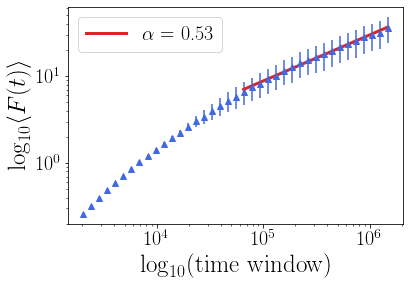

In [26]:
a,b,c,e = dfa(mup, scale_lim = [11,maxsc], xmin = 16, overlap = 0.5);
cc = plot_fluct(a,b,e,show = 1, xmin = 16)

The dfa predicts an exponent close to $0.5$, i. e. close to the exponent that characterizes white noise, and that is consistent with the nature of this up state.

## Transition between up state and collective oscillations

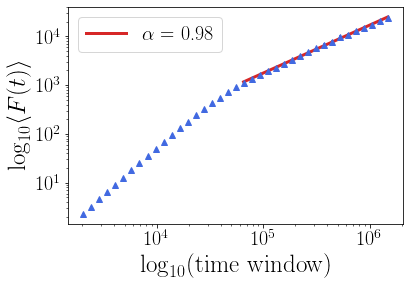

In [27]:
a,b,c,e = dfa(mcrit,scale_lim = [11,maxsc], xmin = 16, overlap = 0.5)
cc = plot_fluct(a,b,e,show =1,xmin = 16)

The dfa here predicts an exponent close to 1. This points to $1/f$ noise and long range correlations, proper of critical points. We are thus likely close to a bona fide critical point.

## Collective oscillations state

In [28]:
maxsc

20.516531070045332

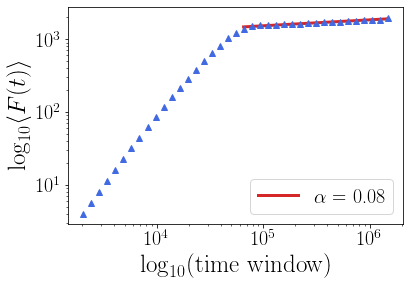

In [29]:
a,b,c,e = dfa(msinc,scale_lim = [11,maxsc], xmin = 14, overlap = 0.5)
cc = plot_fluct(a,b,e,show =1, xmin= 16)

In this region the dfa correctly predicts an exponents of 0, proper of pure oscillations, in which the variance of the signal neither dies out or increases when taking larger window lengths, but always stays the same. However, with the prospect of applying this method to real data, be careful that the real scaling appears after some order of magnitudes! (that depend on the period of the oscillations, which in this case is really large).

## NB: the correct scaling emerges just after some orders of magnitudes!

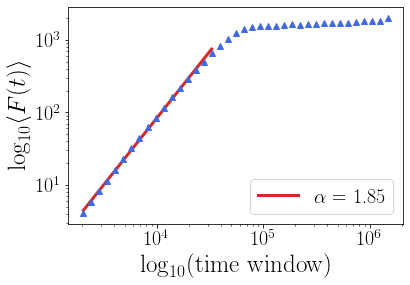

In [31]:
a,b,c,e = dfa(msinc,scale_lim = [11,maxsc], xmin = 14, overlap = 0)
cc = plot_fluct(a,b,e,show =1, xmin = 11,xmax = 15)